In [1]:
# Basic libraries
import os
import random
from collections import defaultdict
from datetime import datetime as dt
import warnings

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Machine learning libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    mean_squared_log_error
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    AdaBoostRegressor
)
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, DotProduct, WhiteKernel
import xgboost as xgb

# Time series libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_white
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from arch import arch_model
import pmdarima as pm
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter

# Libraries for Statistical Models
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_white
from scipy.stats import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

# LightGBM library
import lightgbm as lgb

# Set options
%matplotlib inline
warnings.filterwarnings("ignore")


In [84]:
# add date tiem features
def add_datetime_features(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    df_copy = df.copy()

    # Extract year, month, and day information
    df_copy['year'] = df_copy.index.year
    df_copy['month'] = df_copy.index.month
    df_copy['day'] = df_copy.index.day
    df_copy['weekday'] = df_copy.index.weekday

    return df_copy


def generate_lagged_features(df, var, max_lag):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    ts_data = df.copy()
    for t in range(1, max_lag + 1):
        ts_data[var + '_lag' + str(t)] = ts_data[var].shift(t)
    # print(ts_data.head())
    # print(ts_data.tail())
    # print(ts_data.shape)
    ts_data.dropna(inplace=True)

    return ts_data

# def prepare_time_series_data(df, var, max_lag):
#     # Generate lagged features
#     lagged_data = generate_lagged_features(df, var, max_lag)

#     # Add datetime features
#     if not isinstance(lagged_data.index, pd.DatetimeIndex):
#         lagged_data.index = pd.to_datetime(lagged_data.index)
#     transformed_data = add_datetime_features(lagged_data)

#     return transformed_data


def extract_column(df, column_name):
    extracted_column = df[column_name]
    remaining_df = df.drop(column_name, axis=1)
    return remaining_df, extracted_column

# def scale_data(train_data, test_data):
#     scaler = MinMaxScaler()
#     train_scaled = scaler.fit_transform(train_data)
#     test_scaled = scaler.transform(test_data)
#     return train_scaled, test_scaled, scaler


def scale_data(train_data, test_data, target_column):
    # scaler_X = MinMaxScaler()
    # scaler_Y = MinMaxScaler()
    # scaler_X = StandardScaler()
    # scaler_Y = StandardScaler()
    scaler_X = RobustScaler()
    scaler_Y = RobustScaler()

    train_X = train_data.drop(target_column, axis=1)
    # print(train_X)
    # train_X = train_data
    train_Y = train_data[[target_column]]
    # print(train_Y)
    test_X = test_data.drop(target_column, axis=1)
    # test_X = test_data
    test_Y = test_data[[target_column]]
    # print('xscaled')
    train_X_scaled = scaler_X.fit_transform(train_X)
    # print(train_X_scaled.shape)
    train_Y_scaled = scaler_Y.fit_transform(train_Y)
    # print('yscaled')
    # print(train_Y_scaled.shape)
    test_X_scaled = scaler_X.transform(test_X)
    test_Y_scaled = scaler_Y.transform(test_Y)

    # train_data_scaled = np.concatenate((train_X_scaled, train_Y_scaled), axis=1)
    # test_data_scaled = np.concatenate((test_X_scaled, test_Y_scaled), axis=1)
    train_data_scaled = pd.concat([pd.DataFrame(train_X_scaled, columns=train_X.columns, index=train_X.index),
                                   pd.DataFrame(train_Y_scaled, columns=train_Y.columns, index=train_Y.index)], axis=1)
    test_data_scaled = pd.concat([pd.DataFrame(test_X_scaled, columns=test_X.columns, index=test_X.index),
                                  pd.DataFrame(test_Y_scaled, columns=test_Y.columns, index=test_Y.index)], axis=1)

    # print(train_data_scaled.shape)
    return train_data_scaled, test_data_scaled, scaler_X, scaler_Y

# def scale_data(train_data, test_data, target_column):
#     scaler_X = MinMaxScaler()
#     scaler_Y = MinMaxScaler()

#     train_X = train_data.drop(target_column, axis=1)
#     train_Y = train_data[[target_column]]
#     test_X = test_data.drop(target_column, axis=1)
#     test_Y = test_data[[target_column]]

#     # Identify non-binary columns
#     non_binary_columns = [col for col in train_X.columns if 'outliers' not in col]

#     # Scale only non-binary columns
#     train_X[non_binary_columns] = scaler_X.fit_transform(train_X[non_binary_columns])
#     test_X[non_binary_columns] = scaler_X.transform(test_X[non_binary_columns])

#     train_Y_scaled = scaler_Y.fit_transform(train_Y)
#     test_Y_scaled = scaler_Y.transform(test_Y)

#     train_data_scaled = np.concatenate((train_X, train_Y_scaled), axis=1)
#     test_data_scaled = np.concatenate((test_X, test_Y_scaled), axis=1)

#     return train_data_scaled, test_data_scaled, scaler_X, scaler_Y


def unscale_data(pred, actual, scaler):
    pred = scaler.inverse_transform(pred)
    actual = scaler.inverse_transform(actual)
    return pred, actual


In [8]:
def standardize_series(series):
    return StandardScaler().fit_transform(series.values.reshape(-1, 1))


def apply_dbscan_clustering(series_standardized, eps=0.5, min_samples=2):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    return dbscan.fit_predict(series_standardized)


def extract_outliers_from_clusters(series, clusters):
    """Identify the outliers (cluster label -1 indicates an outlier)"""
    return series[clusters == -1]


def cluster_based_outlier_detection(series):
    series_standardized = standardize_series(series)
    clusters = apply_dbscan_clustering(series_standardized, eps=0.15)
    outliers = extract_outliers_from_clusters(series, clusters)
    # print('Outliers shape: {}'.format(outliers.shape))
    # Create a DataFrame with the same index as the original series
    outliers_df = pd.DataFrame(index=series.index)
    outliers_df['outliers'] = 0
    outliers_df.loc[outliers.index, 'outliers'] = 1

    return outliers_df


def prepare_time_series_data(df, var, max_lag, detect_outliers=False):
    # Generate lagged features
    lagged_data = generate_lagged_features(df, var, max_lag)
    # print('Lagged data shape: {}'.format(lagged_data.shape))

    # Add outlier features if detect_outliers is True
    if detect_outliers:
        series = df[var].pow(2)
        series.dropna(inplace=True)
        # print('Series shape: {}'.format(series.shape))
        outliers_df = cluster_based_outlier_detection(series)
        # print('Outliers DataFrame shape: {}'.format(outliers_df.shape))
        lagged_outliers = generate_lagged_features(
            outliers_df, 'outliers', max_lag)
        # print('Lagged outliers shape: {}'.format(lagged_outliers.shape))
        lagged_data = lagged_data.merge(
            lagged_outliers, left_index=True, right_index=True)
        # print('Lagged data shape: {}'.format(lagged_data.shape))

    # Add datetime features
    if not isinstance(lagged_data.index, pd.DatetimeIndex):
        lagged_data.index = pd.to_datetime(lagged_data.index)
    # transformed_data = add_datetime_features(lagged_data)
    transformed_data = lagged_data
    # Drop rows with missing values
    transformed_data.dropna(inplace=True)

    return transformed_data


In [4]:
def load_raw_data(filename):
    raw_df = pd.read_csv(filename, header=None)
    raw_df.columns = ['datetime', 'ts1', 'ts2']
    raw_df['datetime'] = pd.to_datetime(
        raw_df['datetime'] - 719529, unit='d').round('s')
    raw_df.set_index('datetime', inplace=True)
    raw_df.dropna(inplace=True)
    return raw_df


def calculate_log_returns(df):
    rt = np.log(df / df.shift(1))
    rt.dropna(inplace=True)
    return rt


def load_clean_data(filename):
    clean_df = pd.read_csv(filename)
    clean_df.columns = ['datetime', 'ts1', 'ts2']
    clean_df.set_index('datetime', inplace=True)
    clean_df.index = pd.to_datetime(clean_df.index)
    return clean_df


In [96]:
def process_data(train_data, test_data, lags, input_column, target_column, detect_outliers=False):
    # Create new dataframes with input and target columns
    input_train = train_data[[input_column]]
    input_test = test_data[[input_column]]
    input_train.columns = ['input']
    input_test.columns = ['input']
    target_train = train_data[[target_column]]
    target_test = test_data[[target_column]]
    target_train.columns = ['target']
    target_test.columns = ['target']

    train_data = pd.concat([input_train, target_train], axis=1)
    test_data = pd.concat([input_test, target_test], axis=1)
    train_data_datetime = add_datetime_features(train_data)
    test_data_datetime = add_datetime_features(test_data)

    # Scale the data
    train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(
        train_data_datetime, test_data_datetime, 'target')

    # Prepare time series data
    train_transformed = prepare_time_series_data(
        train_data_scaled, 'input', lags, detect_outliers=detect_outliers)
    test_transformed = prepare_time_series_data(
        test_data_scaled, 'input', lags, detect_outliers=detect_outliers)

    # Drop the input column
    train_transformed = train_transformed.drop('input', axis=1)
    test_transformed = test_transformed.drop('input', axis=1)

    # Extract X and Y
    X_train, Y_train = extract_column(train_transformed, 'target')
    X_test, Y_test = extract_column(test_transformed, 'target')

    return X_train, Y_train, X_test, Y_test


In [97]:
def split_series(series, split_date):
    series.index = pd.to_datetime(series.index)
    split_date = pd.Timestamp(split_date)

    before_split = series.loc[series.index <= split_date]
    after_split = series.loc[series.index > split_date]

    return before_split, after_split


In [98]:
# load raw data
df = load_raw_data("Test_data.csv")
# calcualte log returns
raw_rt = calculate_log_returns(df)
raw_rt_daily = raw_rt.resample('D').mean()

df = load_clean_data('interpolate_clean_df.csv')
# calcualte log returns
imp_rt = calculate_log_returns(df)
imp_rt_daily = imp_rt.resample('D').mean()


In [99]:
# prerpare train and test experiments
train_imp, test_imp = split_series(imp_rt_daily, '2011-12-31')
train_raw, test_raw = split_series(raw_rt_daily, '2011-12-31')


In [6]:
test_size = 14
n_splits = 30
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
lags = 3


In [108]:

X_train, Y_train, X_test, Y_test = process_data(
    train_imp, test_raw, lags, detect_outliers=True, input_column='ts1', target_column='ts1')


In [ ]:
# H1
hypothesis = 'H1'
hypothesis_results = {}
# EX1
X_train, Y_train, X_test, Y_test = process_data(
    train_raw, test_raw, lags, detect_outliers=False, input_column='ts1', target_column='ts1')
experiment = 'Raw_no_outliers'+"_split_" + \
    str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train,
                         X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment] = results

# EX2
X_train, Y_train, X_test, Y_test = process_data(
    train_raw, test_raw, lags, detect_outliers=True, input_column='ts1', target_column='ts1')
experiment = 'Raw_outliers'+"_split_" + \
    str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train,
                         X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment] = results

# EX3
X_train, Y_train, X_test, Y_test = process_data(
    train_imp, test_raw, lags, detect_outliers=False, input_column='ts1', target_column='ts1')
experiment = 'Imputed_no_outliers'+"_split_" + \
    str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train,
                         X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment] = results

# EX4
X_train, Y_train, X_test, Y_test = process_data(
    train_imp, test_raw, lags, detect_outliers=True, input_column='ts1', target_column='ts1')
experiment = 'Impute_outliers'+"_split_" + \
    str(n_splits)+"_test_size_"+str(test_size)
results = run_experiment(models_and_param_grids, X_train, Y_train,
                         X_test, Y_test, tscv, scaler_Y, hypothesis, experiment)
hypothesis_results[experiment] = results


In [94]:
detect_outliers = True
train_data, test_data = raw_rt_daily.iloc[:int(
    len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]
input_column = 'ts2'
target_column = 'ts2'
# Create new dataframes with input and target columns
input_train = train_data[[input_column]]
input_test = test_data[[input_column]]
input_train.columns = ['input']
input_test.columns = ['input']
target_train = train_data[[target_column]]
target_test = test_data[[target_column]]
target_train.columns = ['target']
target_test.columns = ['target']

train_data = pd.concat([input_train, target_train], axis=1)
test_data = pd.concat([input_test, target_test], axis=1)
train_data_datetime = add_datetime_features(train_data)
test_data_datetime = add_datetime_features(test_data)

# Scale the data
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(
    train_data_datetime, test_data_datetime, 'target')
# Prepare time series data
train_transformed = prepare_time_series_data(
    train_data_scaled, 'input', lags, detect_outliers=detect_outliers)
test_transformed = prepare_time_series_data(
    test_data_scaled, 'input', lags, detect_outliers=detect_outliers)
# Drop the input column
train_transformed = train_transformed.drop('input', axis=1)
test_transformed = test_transformed.drop('input', axis=1)
# Extract X and Y
X_train, Y_train = extract_column(train_transformed, 'target')
X_test, Y_test = extract_column(test_transformed, 'target')


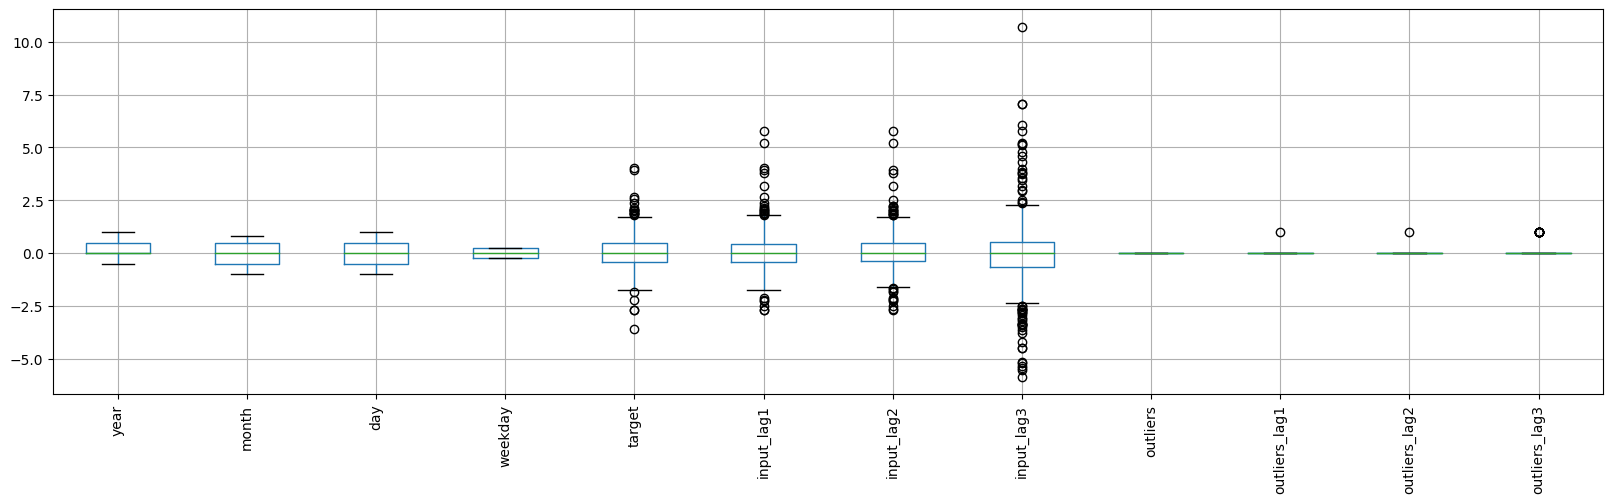

In [91]:
train_transformed.boxplot(figsize=(20, 5))
plt.xticks(rotation=90)
plt.show()


In [ ]:
train_data = train_data[[input_column, target_column]]
test_data = test_data[[input_column, target_column]]
train_data = train_data.rename(
    columns={input_column: 'input', target_column: 'target'})
test_data = test_data.rename(
    columns={input_column: 'input', target_column: 'target'})
train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(
    train_data, test_data, 'target')
train_data_df = pd.DataFrame(
    train_data_scaled, index=train_data.index, columns=train_data.columns)
test_data_df = pd.DataFrame(
    test_data_scaled, index=test_data.index, columns=test_data.columns)


In [ ]:
def prep_H1_data(train_data, test_data, lags, input_column, target_column, detect_outliers=False):
    # Create new dataframes with input and target columns
    train_data = train_data[[input_column, target_column]].rename(
        columns={input_column: 'input', target_column: 'target'})
    test_data = test_data[[input_column, target_column]].rename(
        columns={input_column: 'input', target_column: 'target'})

    # Scale the data
    train_data_scaled, test_data_scaled, scaler_X, scaler_Y = scale_data(
        train_data, test_data, 'target')

    # Convert scaled data back to dataframes
    train_data_df = pd.DataFrame(
        train_data_scaled, index=train_data.index, columns=train_data.columns)
    test_data_df = pd.DataFrame(
        test_data_scaled, index=test_data.index, columns=test_data.columns)

    # Prepare time series data
    train_transformed = prepare_time_series_data(
        train_data_df, 'input', lags, detect_outliers=detect_outliers)
    test_transformed = prepare_time_series_data(
        test_data_df, 'input', lags, detect_outliers=detect_outliers)

    # Drop the input column
    train_transformed = train_transformed.drop('input', axis=1)
    test_transformed = test_transformed.drop('input', axis=1)

    print(train_transformed)

    # Extract X and Y
    X_train, Y_train = extract_column(train_transformed, 'target')
    X_test, Y_test = extract_column(test_transformed, 'target')
    print(X_train)

    return X_train, Y_train, X_test, Y_test


train_data, test_data = raw_rt_daily.iloc[:int(
    len(raw_rt_daily)*0.8), :], raw_rt_daily.iloc[int(len(raw_rt_daily)*0.8):, :]

xt, yt, xts, yts = prep_H1_data(
    train_data, test_data, lags, detect_outliers=True)
train_data_df.boxplot(figsize=(20, 5))
plt.xticks(rotation=90)
plt.show()


In [ ]:
model = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 3, 5, 10]
}
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
X_train, Y_train, X_test, Y_test, scaler_X, scaler_Y = process_data(
    train_raw, test_raw, lags, detect_outliers=False, input_column='ts1', target_column='ts1')


def mean_absolute_scaled_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / 1.48)


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring=mean_absolute_scaled_error,
    verbose=3,
    n_jobs=-1,
)
grid_search.fit(X_train, Y_train)
best_model = grid_search.best_estimator_
cv_results = grid_search.cv_results_
# mean_score = -np.mean(cv_results['mean_test_score'])
# std_score = np.std(cv_results['mean_test_score'])
